In [1]:
import os
import random
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from pathlib import Path
from PIL import Image
from torchvision import transforms, models

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

print('Torch version:', torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Torch version: 2.7.0+cpu
Device: cpu


In [2]:
root_dir = './data/spectrograms/'
image_dir = './data/spectrograms/'
image_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")

Found 1839 images.


In [3]:
def set_seed(seed=30):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cleanup_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

In [4]:
class CustomSpectrogramDataset(Dataset):
    def __init__(self, root_dir, annotation_file=None, transform=None, image_size=(224, 224)):
        self.root_dir = Path(root_dir)
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}

        self.samples = []

        if annotation_file:
            # Read file list and resolve each path
            with open(annotation_file, 'r') as f:
                listed_files = [ln.strip() for ln in f if ln.strip()]

            for rel_path in listed_files:
                rel_path = rel_path.replace("\\", "/")  # normalize for Windows
                cls_name = rel_path.split('/')[0]       # first part = class folder
                if cls_name not in self.class_to_idx:
                    print(f"Skipping {rel_path} (unknown class '{cls_name}')")
                    continue

                full_path = self.root_dir / rel_path
                if full_path.exists():
                    self.samples.append((str(full_path), self.class_to_idx[cls_name]))
                else:
                    print(f"Missing file: {full_path}")
        else:
            # No annotation file → just take all PNGs
            for cls in self.classes:
                for full in (self.root_dir / cls).glob("*.png"):
                    self.samples.append((str(full), self.class_to_idx[cls]))

        if len(self.samples) == 0:
            raise ValueError(f"No spectrogram samples found in {root_dir} with given annotation file.")

        self.transform = transform or transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)


In [5]:
# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(112, scale=(0.8, 1.0)),  # Random crop (time/freq region)
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1)
#     ], p=0.5),
#     transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Small shift in time/freq
#     transforms.ToTensor(),
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
# ])

train_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Validation transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
DATA_ROOT = './data/spectrograms/'
TRAIN_LIST = './data/splits/train.txt'
VAL_LIST   = './data/splits/val.txt'
TEST_LIST  = './data/splits/test.txt'

In [7]:
# Load datasets once
train_ds = CustomSpectrogramDataset(DATA_ROOT, TRAIN_LIST, transform=train_transforms)
val_ds = CustomSpectrogramDataset(DATA_ROOT, VAL_LIST, transform=val_transforms)
test_ds = CustomSpectrogramDataset(DATA_ROOT, TEST_LIST, transform=val_transforms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)

Class label: 3 (Pneumonia)


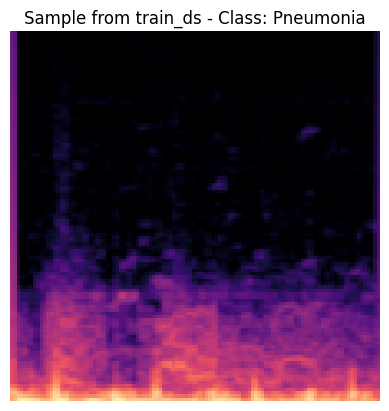

In [8]:
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Pick a random sample
sample_idx = random.randint(0, len(train_ds) - 1)
image, label = train_ds[sample_idx]

# Get class name (if available)
class_name = [k for k, v in train_ds.class_to_idx.items() if v == label.item()][0]

print(f"Class label: {label.item()} ({class_name})")
imshow(image)
plt.title(f"Sample from train_ds - Class: {class_name}")
plt.show()

In [9]:
def print_model_parameters(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n--- {model_name} Parameters ---")
    print(f"Total Parameters:     {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")

In [10]:
# model factory functions
def get_teacher(num_classes=4, pretrained=True): #num_classes=6
    try:
        if pretrained:
            teacher = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        else:
            teacher = models.resnet50(weights=None)
    except Exception as e:
        print('Warning: could not load ResNet50 pretrained weights:', e)
        teacher = models.resnet50(weights=None)
    teacher.fc = nn.Linear(teacher.fc.in_features, num_classes)
    return teacher

def get_student(num_classes=4, pretrained=True):
    try:
        if pretrained:
            student = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
        else:
            student = models.mobilenet_v2(weights=None)
    except Exception as e:
        print('Warning: could not load MobileNetV2 pretrained weights:', e)
        student = models.mobilenet_v2(weights=None)
    student.classifier[1] = nn.Linear(student.last_channel, num_classes)
    return student

In [11]:
# teacher finetuning
def finetune_teacher(teacher, train_loader, val_loader, device, epochs=15, lr=1e-4, save_path=None):
    """Memory-efficient teacher finetuning with reduced epochs"""
    teacher = teacher.to(device)
    teacher.train()
    optimizer = torch.optim.Adam(teacher.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()

    best_acc = 0.0
    best_state = None
    
    for epoch in range(epochs):
        teacher.train()
        running_loss = 0.0
        total = 0; correct = 0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            
            with autocast():
                outs = teacher(imgs)
                loss = criterion(outs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
            _, preds = torch.max(outs, 1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
            
            # Memory cleanup every 20 batches
            if batch_idx % 20 == 0:
                del imgs, labels, outs
                cleanup_memory()

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.*correct/total if total>0 else 0.0

        # Validation
        teacher.eval()
        val_loss = 0.0; total=0; correct=0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                
                with autocast():
                    outs = teacher(imgs)
                    loss = criterion(outs, labels)
                
                val_loss += loss.item()
                _, preds = torch.max(outs,1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()
                
                del imgs, labels, outs
                
        avg_val_loss = val_loss / max(1, len(val_loader))
        val_acc = 100.*correct/total if total>0 else 0.0

        scheduler.step(avg_val_loss)
        if epoch % 10 == 0: 
            print(f'Epoch {epoch+1}/{epochs} - train_loss: {avg_train_loss:.4f} train_acc: {train_acc:.2f}% - val_loss: {avg_val_loss:.4f} val_acc: {val_acc:.2f}%')

        if val_acc > best_acc:
            best_acc = val_acc
            best_state = copy.deepcopy(teacher.state_dict())
            if save_path:
                torch.save(best_state, save_path)

        cleanup_memory()

    if best_state is not None:
        teacher.load_state_dict(best_state)
    teacher.eval()
    cleanup_memory()
    return teacher, best_acc

In [12]:
# knowledge distillation training
def train_student_kd(
    teacher, student, train_loader, val_loader, device,
    epochs=30, lr=1e-4, alpha=0.7, temperature=4.0,
    save_path='./student.pth'
):
    """Ultra memory-efficient knowledge distillation training"""
    # Move models to device
    teacher.to(device)
    student.to(device)
    teacher.eval()  # Keep teacher in eval mode
    
    # Freeze teacher completely to save memory
    for param in teacher.parameters():
        param.requires_grad = False
    
    optimizer = torch.optim.Adam(student.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    scaler = GradScaler()

    best_val_acc = 0.0
    history = {
        'train_ce_loss': [], 'train_mse_loss': [], 'train_total_loss': [],
        'val_ce_loss': [], 'val_mse_loss': [], 'val_total_loss': [],
        'val_acc': []
    }

    print(f"Training with temperature={temperature}, alpha={alpha} (KD weight)")
    print("Using ultra memory-efficient KD")

    for epoch in range(epochs):
        # ==== TRAIN ====
        student.train()
        ce_sum, mse_sum, total_sum = 0.0, 0.0, 0.0
        
        for batch_idx, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            # Get teacher outputs (no gradients needed)
            with torch.no_grad():
                teacher_outputs = teacher(imgs).detach()

            optimizer.zero_grad()

            with autocast():
                student_outputs = student(imgs)

                # Calculate losses
                ce_loss = F.cross_entropy(student_outputs, labels)
                
                # mse losses
                teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
                student_soft = F.softmax(student_outputs / temperature, dim=1)
                mse_loss = F.mse_loss(student_soft, teacher_soft) * (temperature ** 2)
                
                # Combined loss
                total_loss = alpha * mse_loss + (1 - alpha) * ce_loss

            scaler.scale(total_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Track losses
            ce_sum += ce_loss.item()
            mse_sum += mse_loss.item()
            total_sum += total_loss.item()

            # Aggressive memory cleanup every 10 batches
            if batch_idx % 10 == 0:
                del imgs, labels, teacher_outputs, student_outputs, ce_loss, mse_loss, total_loss
                cleanup_memory()

        avg_train_ce = ce_sum / len(train_loader)
        avg_train_mse = mse_sum / len(train_loader)
        avg_train_total = total_sum / len(train_loader)

        # ==== VALIDATION ====
        student.eval()
        ce_sum, mse_sum, total_sum = 0.0, 0.0, 0.0
        total, correct = 0, 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                with autocast():
                    teacher_outputs = teacher(imgs)
                    student_outputs = student(imgs)

                    # Calculate losses
                    # Hard-label supervision
                    ce_loss = F.cross_entropy(student_outputs, labels)
                    
                    # Soft-label supervision (teacher guidance)
                    teacher_soft = F.softmax(teacher_outputs / temperature, dim=1)
                    student_soft = F.softmax(student_outputs / temperature, dim=1)
                    mse_loss = F.mse_loss(student_soft, teacher_soft) * (temperature ** 2)
                    
                    # Total loss (weighted)
                    total_loss = alpha * mse_loss + (1 - alpha) * ce_loss
                ce_sum += ce_loss.item()
                mse_sum += mse_loss.item()
                total_sum += total_loss.item()

                _, preds = torch.max(student_outputs, 1)
                total += labels.size(0)
                correct += preds.eq(labels).sum().item()

                del imgs, labels, teacher_outputs, student_outputs

        avg_val_ce = ce_sum / len(val_loader)
        avg_val_mse = mse_sum / len(val_loader)
        avg_val_total = total_sum / len(val_loader)
        val_acc = 100.0 * correct / total if total > 0 else 0.0

        scheduler.step(avg_val_total)

        # Store history
        history['train_ce_loss'].append(avg_train_ce)
        history['train_mse_loss'].append(avg_train_mse)
        history['train_total_loss'].append(avg_train_total)
        history['val_ce_loss'].append(avg_val_ce)
        history['val_mse_loss'].append(avg_val_mse)
        history['val_total_loss'].append(avg_val_total)
        history['val_acc'].append(val_acc)

        if epoch % 1 == 0:  
            print(f"Epoch {epoch+1}/{epochs} "
                  f"- Train CE: {avg_train_ce:.4f} MSE: {avg_train_mse:.4f} Total: {avg_train_total:.4f} "
                  f"- Val CE: {avg_val_ce:.4f} MSE: {avg_val_mse:.4f} Total: {avg_val_total:.4f} "
                  f"- Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(student.state_dict(), save_path)

        cleanup_memory()

    cleanup_memory()
    return student, best_val_acc, history

In [13]:
def save_student_as_tflite(student, example_input, output_path="student_model.tflite"):
    """
    Export a trained PyTorch model to TensorFlow Lite (.tflite)
    without using ONNX or onnx-tf.
    """

    student.eval()

    traced_model = torch.jit.trace(student, example_input)
    torchscript_path = "student_model.pt"
    traced_model.save(torchscript_path)
    print(f"[INFO] TorchScript model saved to {torchscript_path}")

    class TorchModelWrapper(tf.Module):
        def __init__(self, torch_model):
            super().__init__()
            self.torch_model = torch_model

        @tf.function(input_signature=[tf.TensorSpec(shape=example_input.shape, dtype=tf.float32)])
        def __call__(self, x):
            x_torch = torch.from_numpy(x.numpy()).to(next(student.parameters()).device)
            with torch.no_grad():
                y_torch = self.torch_model(x_torch)
            return tf.convert_to_tensor(y_torch.cpu().numpy(), dtype=tf.float32)

    wrapper = TorchModelWrapper(student)

    converter = tf.lite.TFLiteConverter.from_concrete_functions([wrapper.__call__.get_concrete_function()])
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: enable quantization
    tflite_model = converter.convert()

    with open(output_path, "wb") as f:
        f.write(tflite_model)
    print(f"TFLite model exported to {output_path}")

In [14]:
def run_kd(save_tflite=False):
    NUM_CLASSES = 4
    seed = 33  # single run only

    results = {
        'teacher_acc': None,
        'student_acc': None,
        'val_acc': None,
        'train_ce_loss': None,
        'train_mse_loss': None,
        'train_total_loss': None,
        'val_ce_loss': None,
        'val_mse_loss': None,
        'val_total_loss': None,
        'classification_report_teacher': None,
        'classification_report_student': None,
        'confusion_matrix_teacher': None,
        'confusion_matrix_student': None,
        'detailed_metrics_teacher': None,
        'detailed_metrics_student': None
    }

    print("=" * 80)
    print("KNOWLEDGE DISTILLATION EXPERIMENT - SINGLE RUN")
    print(f"Dataset size: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")
    print(f"Classes: {train_ds.classes}")
    print("=" * 80)

    set_seed(seed)
    cleanup_memory()

    # --- Teacher & Student Initialization ---
    teacher = get_teacher(NUM_CLASSES, pretrained=True).to(device)
    student = get_student(NUM_CLASSES, pretrained=True).to(device)

    print_model_parameters(teacher, "Teacher (ResNet50)")
    print_model_parameters(student, "Student (MobileNetV2)")

    # --- Train Teacher ---
    print("Finetuning teacher...")
    teacher, teacher_acc = finetune_teacher(
        teacher, train_loader, val_loader, device,
        epochs=100, lr=1e-4, save_path=f'./teacher.pth'
    )
    print(f"Teacher validation accuracy: {teacher_acc:.2f}%")
    results['teacher_acc'] = teacher_acc

    # --- Function to compute metrics ---
    def compute_metrics(y_true, y_pred, class_names):
        cm = confusion_matrix(y_true, y_pred, labels=range(NUM_CLASSES))
        metrics_summary = {}
        for i, cls in enumerate(class_names):
            TP = cm[i, i]
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            TN = cm.sum() - (TP + FP + FN)

            sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # recall
            specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            f1 = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

            metrics_summary[cls] = {
                'precision': precision,
                'recall (sensitivity)': sensitivity,
                'specificity': specificity,
                'f1_score': f1
            }

        avg_precision = np.mean([m['precision'] for m in metrics_summary.values()])
        avg_recall = np.mean([m['recall (sensitivity)'] for m in metrics_summary.values()])
        avg_specificity = np.mean([m['specificity'] for m in metrics_summary.values()])
        avg_f1 = np.mean([m['f1_score'] for m in metrics_summary.values()])

        metrics_summary['average'] = {
            'precision': avg_precision,
            'recall (sensitivity)': avg_recall,
            'specificity': avg_specificity,
            'f1_score': avg_f1
        }

        return cm, metrics_summary

    # --- Evaluate Teacher on Test Set ---
    print("\nEvaluating TEACHER model on test set...")
    teacher.eval()
    y_true_teacher, y_pred_teacher = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = teacher(imgs)
            _, preds = torch.max(outs, 1)
            y_true_teacher.extend(labels.cpu().numpy())
            y_pred_teacher.extend(preds.cpu().numpy())

    teacher_test_acc = 100.0 * np.mean(np.array(y_true_teacher) == np.array(y_pred_teacher))
    print(f"Teacher Test Accuracy: {teacher_test_acc:.2f}%")
    results['teacher_acc'] = teacher_test_acc

    cm_teacher, metrics_teacher = compute_metrics(y_true_teacher, y_pred_teacher, train_ds.classes)
    results['confusion_matrix_teacher'] = cm_teacher
    results['detailed_metrics_teacher'] = metrics_teacher
    print("\nTeacher Metrics per Class:")
    print(pd.DataFrame(metrics_teacher).T.round(4))

    # --- Train Student with KD ---
    print("\nStarting knowledge distillation...")
    cleanup_memory()
    student, best_val_acc, history = train_student_kd(
        teacher, student, train_loader, val_loader, device,
        epochs=100,
        lr=1e-4,
        alpha=0.7,
        temperature=4.0,
        save_path=f'./student.pth'
    )

    results['val_acc'] = history['val_acc']
    results['train_ce_loss'] = history['train_ce_loss']
    results['train_mse_loss'] = history['train_mse_loss']
    results['train_total_loss'] = history['train_total_loss']
    results['val_ce_loss'] = history['val_ce_loss']
    results['val_mse_loss'] = history['val_mse_loss']
    results['val_total_loss'] = history['val_total_loss']

    # --- Evaluate Student on Test Set ---
    print("\nEvaluating STUDENT model on test set...")
    student.eval()
    y_true_student, y_pred_student = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outs = student(imgs)
            _, preds = torch.max(outs, 1)
            y_true_student.extend(labels.cpu().numpy())
            y_pred_student.extend(preds.cpu().numpy())

    student_test_acc = 100.0 * np.mean(np.array(y_true_student) == np.array(y_pred_student))
    print(f"Student Test Accuracy: {student_test_acc:.2f}%")
    results['student_acc'] = student_test_acc

    cm_student, metrics_student = compute_metrics(y_true_student, y_pred_student, train_ds.classes)
    results['confusion_matrix_student'] = cm_student
    results['detailed_metrics_student'] = metrics_student
    print("\nStudent Metrics per Class:")
    print(pd.DataFrame(metrics_student).T.round(4))

    # --- Confusion Matrix Visualization ---
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_student, display_labels=train_ds.classes)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Student Confusion Matrix - Test Set (Acc: {student_test_acc:.2f}%)')
    plt.show()

    # --- Validation Accuracy Curve ---
    plt.figure(figsize=(8, 5))
    plt.plot(results['val_acc'], color='blue', label='Validation Accuracy')
    plt.title('Validation Accuracy Curve (Student)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- Optional: TFLite Export ---
    if save_tflite:
        print("Converting student model to TFLite (no ONNX)...")

        class TorchModelWrapper(tf.Module):
            def __init__(self, torch_model):
                super().__init__()
                self.torch_model = torch_model

            @tf.function(input_signature=[tf.TensorSpec([None, 3, 224, 224], tf.float32)])
            def __call__(self, x):
                def torch_forward(x_np):
                    x_torch = torch.from_numpy(x_np).to(device)
                    with torch.no_grad():
                        y_torch = self.torch_model(x_torch)
                    return y_torch.cpu().numpy()

                y = tf.py_function(func=torch_forward, inp=[x], Tout=tf.float32)
                y.set_shape([None, NUM_CLASSES])
                return y

        wrapper = TorchModelWrapper(student.eval())
        concrete_func = wrapper.__call__.get_concrete_function()
        converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()

        with open("student_model.tflite", "wb") as f:
            f.write(tflite_model)
        print("Student model saved as student_model.tflite")

    del teacher, student
    cleanup_memory()
    print("Run completed. Memory cleaned.")

    return results

KNOWLEDGE DISTILLATION EXPERIMENT - SINGLE RUN
Dataset size: Train=560, Val=120, Test=120
Classes: ['Asthma', 'COPD', 'Healthy', 'Pneumonia']

--- Teacher (ResNet50) Parameters ---
Total Parameters:     23,516,228
Trainable Parameters: 23,516,228

--- Student (MobileNetV2) Parameters ---
Total Parameters:     2,228,996
Trainable Parameters: 2,228,996
Finetuning teacher...


C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_27916\331947480.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_27916\331947480.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:266:

Epoch 1/100 - train_loss: 1.0192 train_acc: 60.18% - val_loss: 0.6855 val_acc: 74.17%
Epoch 11/100 - train_loss: 0.0565 train_acc: 97.86% - val_loss: 0.4375 val_acc: 85.83%
Epoch 21/100 - train_loss: 0.0051 train_acc: 100.00% - val_loss: 0.4250 val_acc: 89.17%
Epoch 31/100 - train_loss: 0.0044 train_acc: 99.82% - val_loss: 0.4420 val_acc: 87.50%
Epoch 41/100 - train_loss: 0.0046 train_acc: 99.82% - val_loss: 0.4386 val_acc: 87.50%
Epoch 51/100 - train_loss: 0.0047 train_acc: 99.64% - val_loss: 0.4344 val_acc: 89.17%
Epoch 61/100 - train_loss: 0.0046 train_acc: 99.82% - val_loss: 0.4295 val_acc: 87.50%
Epoch 71/100 - train_loss: 0.0042 train_acc: 99.82% - val_loss: 0.4327 val_acc: 89.17%
Epoch 81/100 - train_loss: 0.0041 train_acc: 99.82% - val_loss: 0.4281 val_acc: 88.33%
Epoch 91/100 - train_loss: 0.0047 train_acc: 99.82% - val_loss: 0.4330 val_acc: 88.33%
Teacher validation accuracy: 89.17%

Evaluating TEACHER model on test set...
Teacher Test Accuracy: 81.67%

Teacher Metrics per Cl

C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_27916\4123304489.py:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\ALMIRA\AppData\Local\Temp\ipykernel_27916\4123304489.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
c:\Users\ALMIRA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\amp\autocast_mode.py:2

Epoch 1/100 - Train CE: 1.0905 MSE: 1.2139 Total: 1.1769 - Val CE: 0.7906 MSE: 0.6214 Total: 0.6721 - Val Acc: 70.00%
Epoch 2/100 - Train CE: 0.6308 MSE: 0.7862 Total: 0.7396 - Val CE: 0.5517 MSE: 0.3177 Total: 0.3879 - Val Acc: 82.50%
Epoch 3/100 - Train CE: 0.3465 MSE: 0.5006 Total: 0.4543 - Val CE: 0.4655 MSE: 0.1999 Total: 0.2796 - Val Acc: 87.50%
Epoch 4/100 - Train CE: 0.1710 MSE: 0.3112 Total: 0.2691 - Val CE: 0.5617 MSE: 0.1645 Total: 0.2837 - Val Acc: 85.00%
Epoch 5/100 - Train CE: 0.0990 MSE: 0.1844 Total: 0.1588 - Val CE: 0.4799 MSE: 0.1844 Total: 0.2730 - Val Acc: 85.83%
Epoch 6/100 - Train CE: 0.0350 MSE: 0.1116 Total: 0.0886 - Val CE: 0.5521 MSE: 0.1451 Total: 0.2672 - Val Acc: 85.83%
Epoch 7/100 - Train CE: 0.0225 MSE: 0.0783 Total: 0.0615 - Val CE: 0.5200 MSE: 0.1535 Total: 0.2634 - Val Acc: 85.00%
Epoch 8/100 - Train CE: 0.0272 MSE: 0.0789 Total: 0.0634 - Val CE: 0.5238 MSE: 0.1577 Total: 0.2675 - Val Acc: 83.33%
Epoch 9/100 - Train CE: 0.0247 MSE: 0.0598 Total: 0.0493

<Figure size 1000x800 with 0 Axes>

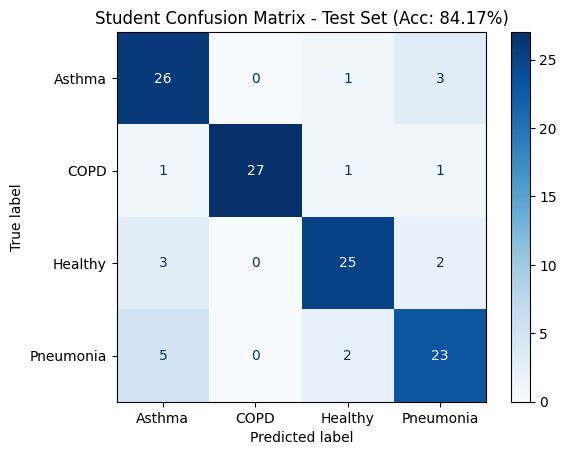

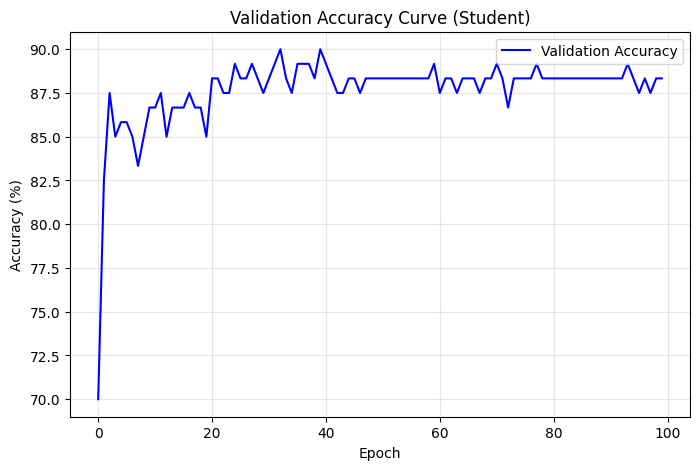

Run completed. Memory cleaned.

Experiment completed.


KeyError: 'test_acc'

In [15]:
if __name__ == "__main__":
    mp.set_start_method('spawn', force=True) 
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    results = run_kd(save_tflite=False)
    print("\nExperiment completed.")
    print(f"Final test accuracy: {results['test_acc']:.2f}%")
